# ELEC 400M / EECE 571M Assignment 2: Neural networks
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will implement a neural network model for multi-class classification. The purpose is to demonstrate an understanding of the basic elements including training of neural network models. Hence, your implementation will be from scratch only using functions from the NumPy library.

The neural network you will be implementing has the following structure:
* 3 layers: 1 input layer, 1 hidden layer with ReLU activation and 1 output layer with Softmax function 􏴣 
* The loss function is the Cross Entropy Loss.
* Training will be done using Gradient Descent with Momentum. 

## Data Set
We again consider the dataset of images of letters in different fonts contained in file notMNIST.npz (which btw is from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This time we consider 10 letters ("A" to "J"), which are all the letters contained in this data set, and we want to classfiy the images according to the letter they display. The figure below shows 30 randomly selected image samples for the letters.

![](sample_images_2.eps)


You will apply the function `loadData` given below to load the data set, which includes 18720 images and their labels, which we also refer to as targets. This script organizes the data set into training, validation and test sets. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Data preprocessing [5 points]

Input data: The classification should be based on the $d=28\times 28=784$ intensity values in an image (as for Assignment 1).

Output data: Since you will be performing multi-class classification, the labels will be converted into a one-hot encoding format. 

Please first briefly explain the meaning of one-hot encoding and why it is used (instead of keeping the numerical label values provided by the data set). State an example for a one-hot encoded label for the data set considered in this assignment.

The image labels are given as integers representing their respective images of numbers 0 through 9. These images are independent character representations and their order is not important. Using integer labels implies an order to the data. Intuitively integers have order, however we need to learn the images related to each number symbol which are independant of order. One hot encoding removes the catgegorical order from the data. 

One hot encoding uses a binary value represent categorical data. In this case, binary represnetaion will have 10 symbols, all of which are zero exept for the entry representing the data value which is 1. For example, integer 0 will be 00 0000 0001 (or 0x01 << 0), and intger 8 will be 01 0000 0000 (or 0x01 << 8). In this assignment, the binary labels are coded in an array of length 10.

Now implement a function that one-hot encodes the labels (or targets) for the training, validation and test sets. 

In [5]:
def convertOneHot(trainTarget, validTarget, testTarget):
    trainTargetOHE = np.eye(10)[trainTarget]
    validTargetOHE = np.eye(10)[validTarget]
    testTargetOHE = np.eye(10)[testTarget]
    return trainTargetOHE, validTargetOHE, testTargetOHE

## Structure of the network [2 points]

Sketch the structure of the network to classify the letters from the data set. Identify the dimensions of the network layers, include the activation functions, and do not forget the bias nodes. (You may sketch this by hand and upload a photo of your sketch.)

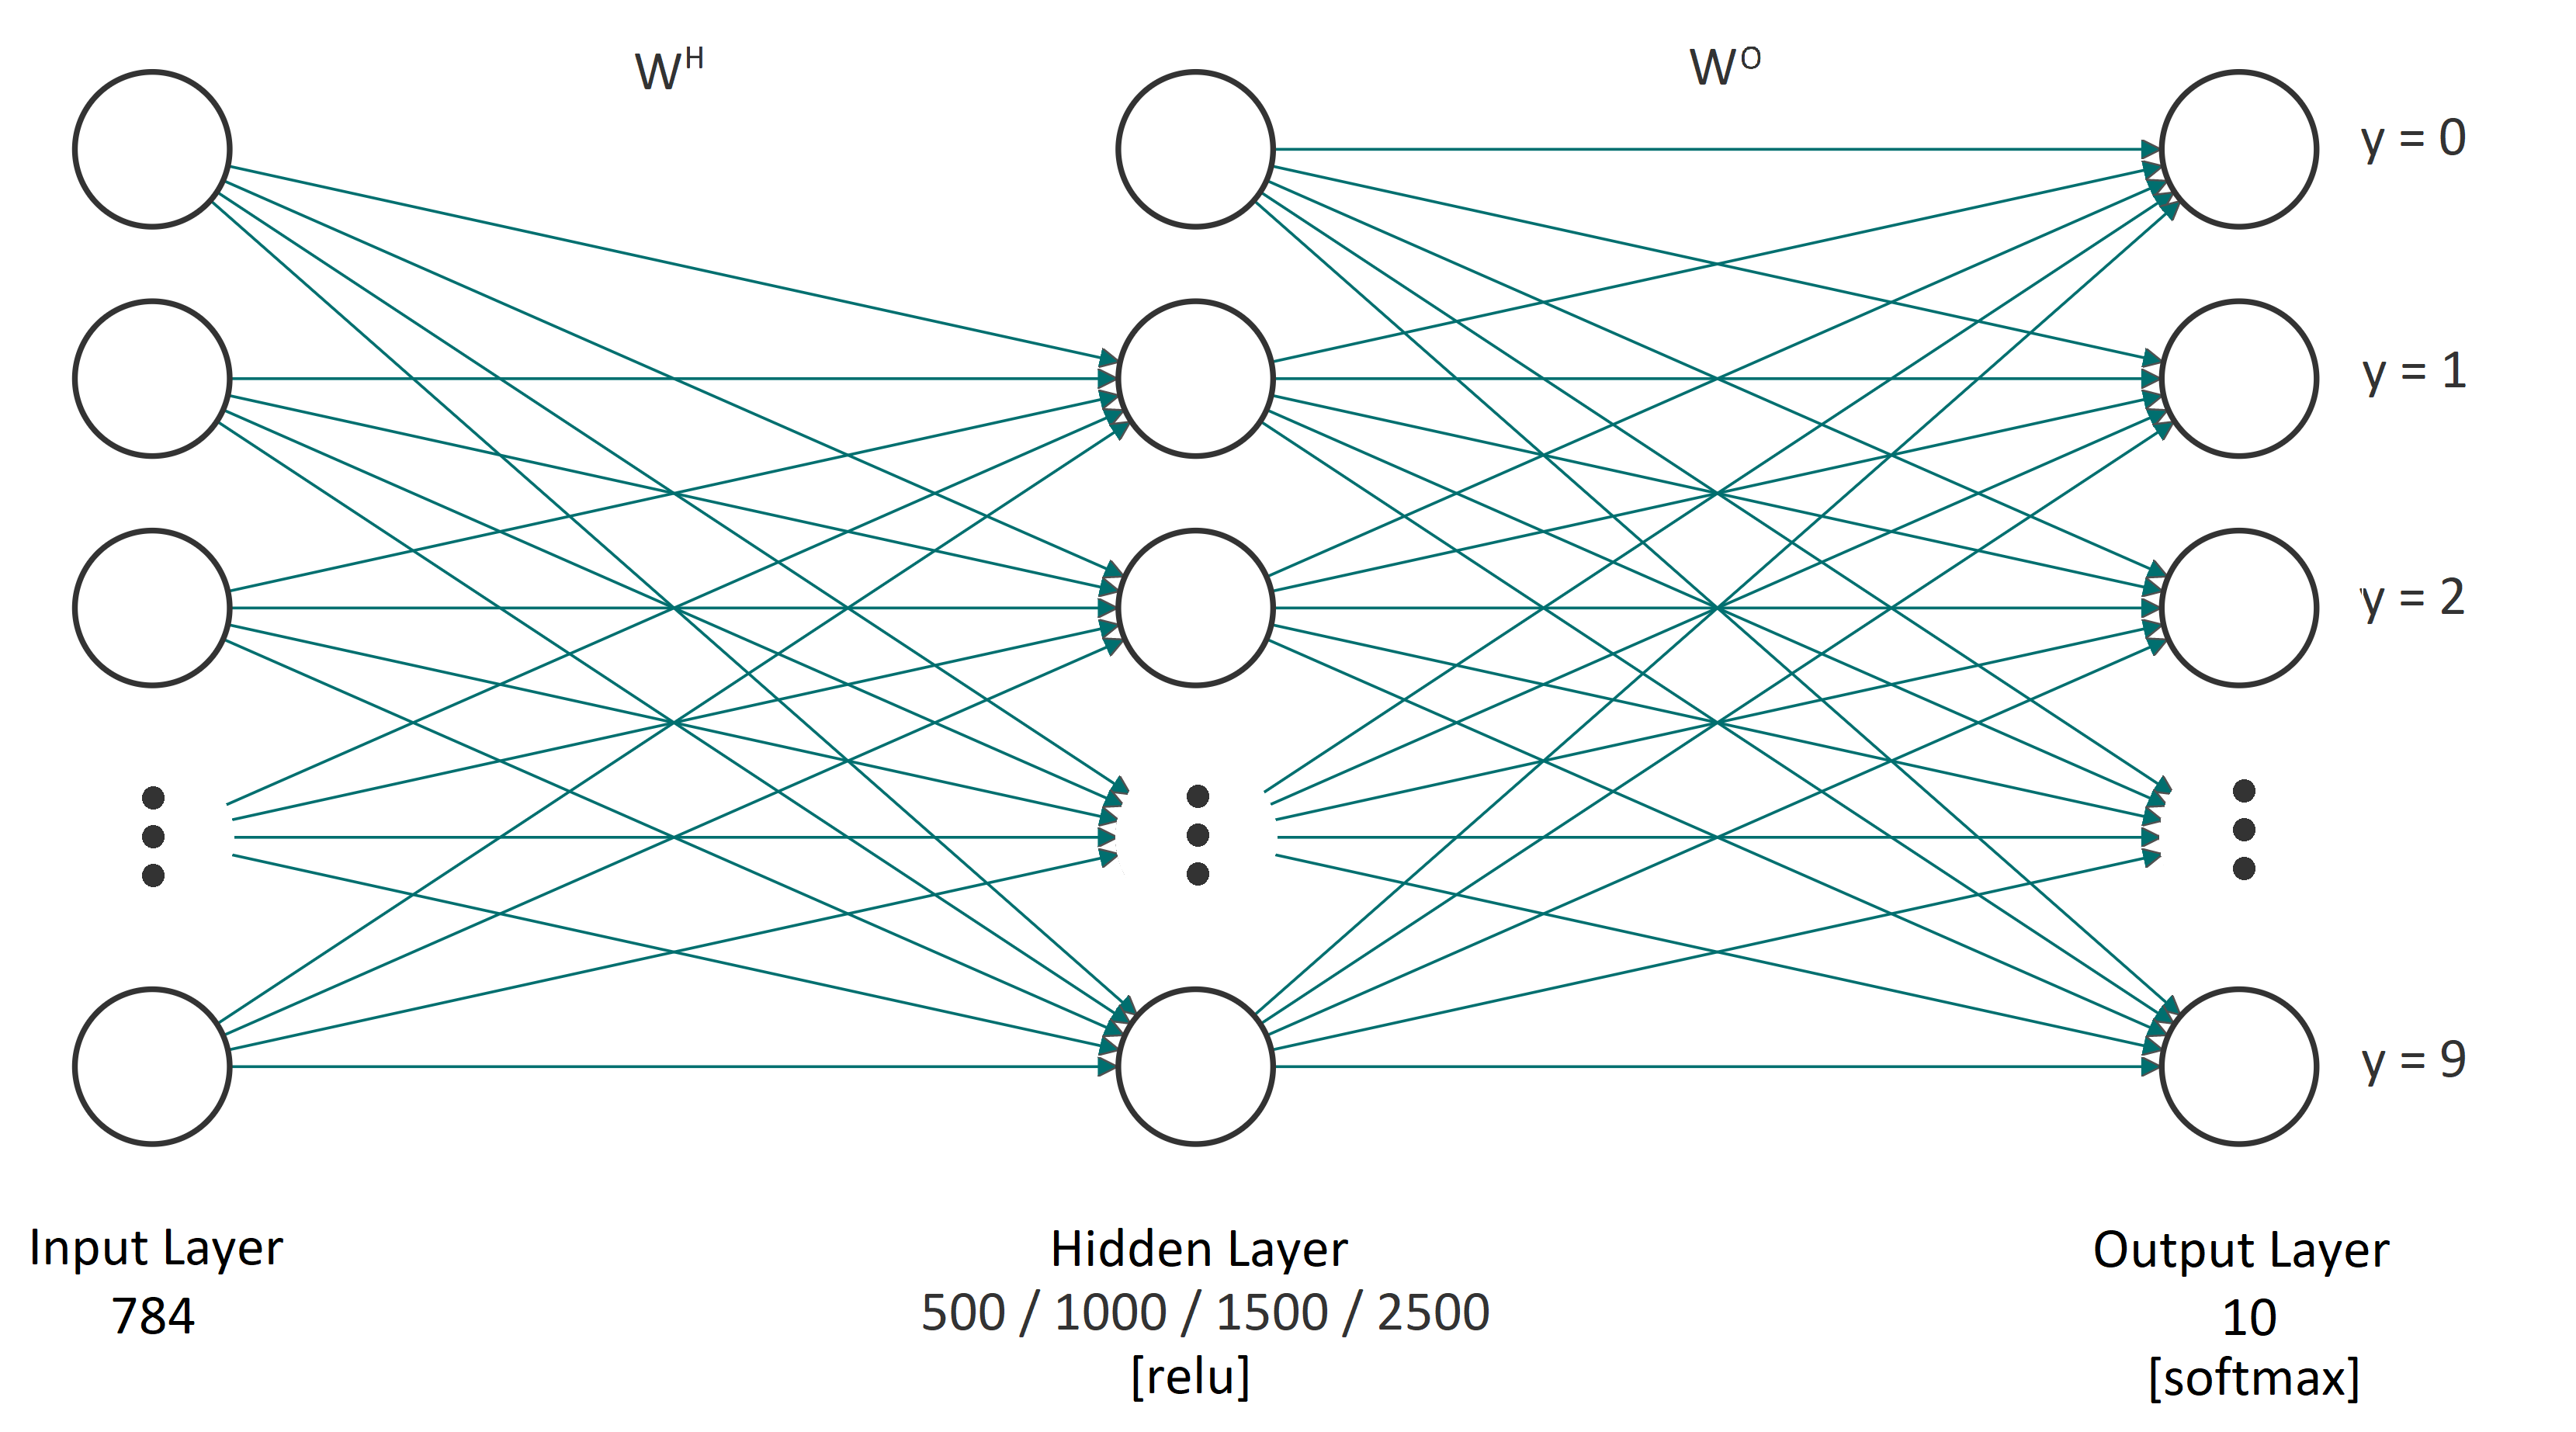

## Helper functions [6 points]
To give the implementation of the network some structure, you will first implement five helper functions. 

Use Numpy arrays for your implementations, and organize data in vectors and matrices as appropriate for compact programming.

1. `relu`: This function will accept one argument and return the ReLU activation: 
    $$\mathrm{ReLU}(x)=\max(0,x).$$
    
2. `softmax`: This function will accept one argument and return the softmax activations:
    $$ [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^K\mathrm{e}^{z_k}},$$ $j=1,2,\ldots, K$,  for $K$ classes.

3. `computeLayer`: This function will accept two arguments, the input vector $\mathbf{x}$ for a layer and the weight matrix $\mathbf{W}$, and return a vector $\mathbf{s}=\mathbf{W}^T\mathbf{x}$, i.e., the input to the activation function of the layer (the notation for variables from the textbook is used). Don't forget to account for the bias term (which can be included in an augmented vector $\mathbf{x}$ as in the textbook).

4. `CE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots N$. It will return the cross entropy loss
$$\mathrm{E}_{\mathrm{in}}=-\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n)]_k)$$

5. `gradCE`: This function will accept two arguments, the labels and the inputs to the softmax function. It will return the gradient of the cross entropy loss with respect to the inputs (i.e., it returns the sensivity vector for the output layer as introduced in the textbook). 

First state the analytical expression for the gradient used in `gradCE` and then implement the five helper functions.

Derivative of Softmax:
$$
\nabla[\sigma(\mathbf{z})]_j = \frac{\partial [\sigma(\mathbf{z})]_i}{\partial a_j} = \frac{\partial  \frac{e^{z_i}}{\sum_{k=1}^N e^{z_k}}}{\partial z_j} = \frac{e^{z_i} \sum_{k=1}^N e^{z_k} - e^{z_j}e^{z_i}}{\left( \sum_{k=1}^N e^{z_k}\right)^2}
$$

The derivative has two results, one when $i=j$ and the other when $i \neq j$. Simplified, the resulting softmax derivative is
$$
\frac{\partial [\sigma(\mathbf{z})]_i}{\partial a_j} = \begin{cases}[\sigma(\mathbf{z})]_i(1-[\sigma(\mathbf{z})]_j) &  if & i=j \\ -[\sigma(\mathbf{z})]_j.[\sigma(\mathbf{z})]_i & if & i \neq j\end{cases}
$$

Derivatice of CE Loss: 

$$ 
\begin{align}
\frac{\partial e}{\partial z_i} &= - \sum_k y_k \frac{\partial log([\sigma(\mathbf{s_n})]_k)}{\partial z_i } \\
&= - \sum y_k \frac{1}{[\sigma(\mathbf{s_n})]_k} \frac{\partial [\sigma(\mathbf{s_n})]_k}{\partial z_i} \\
&= -y_i(1-[\sigma(\mathbf{s_n})]_i) - \sum_{k\neq i} y_k \frac{1}{[\sigma(\mathbf{s_n})]_k}(-[\sigma(\mathbf{s_n})]_k.[\sigma(\mathbf{s_n})]_i) \\
&= [\sigma(\mathbf{s_n})]_i\left( y_i +  \sum_{k \neq 1} y_k\right)  - y_i
\end{align} 
$$

Since the elements in the labels are hot-encoded, only one element is 1 with the rest being o. Therefore
$$
y_i +  \sum_{k \neq 1} y_k = 1
$$

This greatly simplifies the CE gradient, which is also the sensivity vector for the output layer: 
$$
\mathbf{\delta}^{(L)} = \frac{\partial e}{\partial z_i} = [\sigma(\mathbf{s_n})]_i - y_i
$$
$$
\nabla E_{in} =\frac{1}{N}\sum\limits_{n=1}^N \bigl( [\sigma(\mathbf{s_n})] - y_n\bigr)
$$

In [6]:
#inputs: 
#    x = input matrix (#samples x #inputs)
#returns: 
#    matrix (#samples x #inputs)
def relu(x):
    return np.maximum(0, x)

In [7]:
#inputs: 
#    x = input matrix (#samples x #inputs)
#returns: 
#    matrix (#samples x #inputs)
def softmax(x):    
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x, axis=1)
    return exp_x/sum_exp_x.reshape((x.shape[0], 1))

In [8]:
#inputs: 
#    W = weight matrix (#inputs+1 x #outputs) 
#    x = input matrix (#samples x #inputs)
#returns: 
#    matrix (#samples x #layer outputs)
def computeLayer(x,W):
    x = np.hstack( (np.vstack(np.ones(len(x))), x) )
    return (np.matmul(x,W))

In [9]:
#inputs: 
#    target = labels (#samples x 10) 
#    prediction = fwd prop results (#samples x 10)
#returns: 
#    CE Loss (scalar)
def CE(target, prediction):
    ce = -np.mean(np.multiply(target,np.log(prediction)))
    return ce 

In [10]:
#inputs: 
#    target = labels (#samples x 10) 
#    prediction = fwd prop results (#samples x 10)
#returns: 
#    CE gradient matrix (#samples x 10)
def gradCE(target, prediction):
    return prediction - target

## Backpropagation [2 points]

The training of the network will be done via backpropagation. First derive the following gradients:
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$, where $\mathbf{W}^{\mathrm{o}}$ is the weight matrix of the output layer.

2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$, where $\mathbf{W}^{\mathrm{h}}$ is the weight matrix of the hidden layer.

Write the results using the steps and notation used in the textbook.

$$
\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{(\ell)}} = \frac{1}{N}\sum^N_{n=1}\frac{\partial e_n}{\partial \mathbf{W}^{(\ell)}}
$$
$$
where \; \frac{\partial e}{\partial \mathbf{W}^{(\ell)}} = \mathbf{x}^{(\ell-1)}(\mathbf{\delta}^{(\ell)})^T; \;\; \mathbf{\delta^{(\ell)}} = \frac{\partial e}{\partial \mathbf{s^{(\ell)}}}
$$

For the output layer: 
$$
\mathbf{\delta}^{(L)} = [\sigma(\mathbf{s_n}^{(L)})] - y^{(L)}
$$
$$
\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}} = 
\frac{1}{N}\sum^N_{n=1} {x}_n^{(L-1)}\bigl([\sigma(\mathbf{s_n}^{(L)})] - y^{(L)}\bigr)^T
$$

For the hidden layer: 
$$
\mathbf{\delta}^{(h)} = \theta'(\mathbf{s}^{(h)}) \otimes \bigl[ \mathbf{W}^{h+1}\mathbf{\delta}^{h+1}\bigr]^{d^{(h)}}_1
$$
$$
\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}} =
\frac{1}{N}\sum^N_{n=1} {x}_n^{(h)}\bigl(  \theta'(\mathbf{s}^{(h)}) \otimes \bigl[ \mathbf{W}^{h+1}\mathbf{\delta}^{h+1}\bigr]^{d^{(h)}}_1   \bigr)^T
$$
Where the derivative of the Relu activation function is simply: 
$$
\theta'(\mathbf{s}^{(h)}) = \begin{cases} 1 & if & \mathbf{s}^{(h)} > 0 \\ 0 & if & \mathbf{s}^{(h)} \leq 0\end{cases}
$$

## Network training [8 points]

Implement a function to train the network. The function uses the helper functions from above. The optimization technique for backpropagation will be Gradient Descent with Momentum:
$$\mathbf{V}(t)=\alpha \mathbf{V}(t-1)-\eta\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}(t)}$$
and 
$$\mathbf{W}(t+1)=\mathbf{W}(t)+\mathbf{V}(t),$$
where $\eta$ is the learning rate and $\alpha$ is the momentum hyperparameter.

The training function accepts the following inputs:  training data (features), training labels, weight matrix of the hidden layer, weight matrix of the output layer, number of iterations, parameters $\eta$ and $\alpha$, validation data, validation labels, test data, test labels. The validation and test inputs are initialized to "None" and need not be passed on. You will also need to initialize the velocity matrices $\mathbf{V}$ for both hidden layer and output layer weights to small values, e.g. $10^{-5}%$.

The function outputs the updated weight matrices, the losses and classification accuracies for the training data, and if validation and test inputs were provided, then it also outputs the classification accuracies for the validation and test data.

In [11]:
def dRelu(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def trainAccuracy(target, prediction):
    #update predictions to place a 1 for the largest result, 0 for the rest
    matches = np.equal(np.argmax(target, axis = 1), np.argmax(prediction, axis = 1))
    totalMatches = sum(matches == True)
    return totalMatches / target.shape[0]


def fwdProp(trainData, hiddenWeights, outputWeights):
        sH = computeLayer(trainData, hiddenWeights)
        xH = relu(sH)
        sO = computeLayer(xH, outputWeights)
        xO = softmax(sO)
        return sH, sO, xH, xO
    

def trainNN(learningRate, momentum, epochs, hiddenWeights, outputWeights, trainData, 
            trainLabels, validData=None, validLabels=None, testData=None, testLabels=None):
    
    #Switch for processing validation and test data
    doVal = validData is not None and validLabels is not None
    doTest =  testData is not None and testLabels is not None
    
    #Intialize training loss
    Ein = []
    Ein_val = []
    Ein_test = []
    accuracy = []
    accuracy_val = []
    accuracy_test = []
    
    #Initialize V with small values
    vH = np.ones(hiddenWeights.shape)*0.00001
    vO = np.ones(outputWeights.shape)*0.00001
    
    for i in range(epochs):
        
        #Forward Propagate
        sH, sO, xH, xO = fwdProp(trainData, hiddenWeights, outputWeights)
 
        #Log Loss and Accuracy
        Ein.append(CE(trainLabels, xO))
        accuracy.append(trainAccuracy(trainLabels, xO))
        
        if doVal:
            sHval, sOval, xHval, xOval = fwdProp(validData, hiddenWeights, outputWeights)
            Ein_val.append(CE(validLabels, xOval))
            accuracy_val.append(trainAccuracy(validLabels, xOval))
        if doTest: 
            sHtest, sOtest, xHtest, xOtest = fwdProp(testData, hiddenWeights, outputWeights)
            Ein_test.append(CE(testLabels, xOtest))
            accuracy_test.append(trainAccuracy(testLabels, xOtest))
            
        ### Back Proagate ###
        #Compute Sensitivities
        deltaO = gradCE(trainLabels, xO) 
        deltaH = np.multiply(dRelu(sH), np.matmul(deltaO, np.transpose(outputWeights[1:,:])) )
                       
        #Update Error and Gradients
        xIn = np.hstack( (np.vstack(np.ones(trainData.shape[0])), trainData))  
        vH = vH * momentum - learningRate * np.matmul(np.transpose(xIn), deltaH)
        hiddenWeights = hiddenWeights + vH
        
        xH = np.hstack( (np.vstack(np.ones(xH.shape[0])), xH))   
        vO = vO * momentum - learningRate * np.matmul(np.transpose(xH), deltaO)
        outputWeights = outputWeights + vO
        
       
    
    if doVal and doTest:
        return hiddenWeights, outputWeights, Ein, Ein_val, Ein_test, \
            accuracy, accuracy_val, accuracy_test
    else:     
        return hiddenWeights, outputWeights, Ein, accuracy 

## Network test [4 points]

Write a script that constructs the neural network.

Initialize your weight matrices by drawing the elements i.i.d. at random from a zero-mean Gaussian distribution with variance equal to $$\sigma_w^2=\frac{2}{\mbox{# of input nodes + # of output nodes}}$$ (Xavier normalization http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

Build a network with 1000 hidden units and train it for 200 epochs using $\alpha=0.9$ and $\eta=10^{-5}$. Plot the training, validation and testing accuracy curves. State the training, validation and testing accuracies after training. Show the plot and the accuracies in the next markdown cell.

In [ ]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape((trainData.shape[0], -1))
validData = validData.reshape((validData.shape[0], -1))
testData = testData.reshape((testData.shape[0], -1))
trainTarget, validTarget, testTarget = convertOneHot(trainTarget, validTarget, testTarget)

learningRate = 0.00001
momentum = 0.9
hidden_nodes = 1000
epochs = 200
mu = 0

#Initialize Weights with Xavier normalization and no bias weights
hiddenVariance = 2 / (trainData.shape[1] + hidden_nodes)
outputVariance = 2 / (hidden_nodes + 10)
hiddenWeights0 = np.random.normal(mu, np.sqrt(hiddenVariance), (trainData.shape[1] + 1, hidden_nodes))
outputWeights0 = np.random.normal(mu, np.sqrt(outputVariance), (hidden_nodes + 1,10))
outputWeights0[0,:] = 0
hiddenWeights0[0,:] = 0

hiddenWeights0, outputWeights0, Ein0, Ein_val0, Ein_test0, accuracy0, accuracy_val0, accuracy_test0 \
    = trainNN(learningRate, momentum, \
    epochs, hiddenWeights0, outputWeights0, trainData, trainTarget, \
    validData, validTarget, testData, testTarget)
    
#Plot Training Losses
plt.suptitle('Training Loss per Epoch', fontsize = '20')
plt.plot(Ein0, label='Training');
plt.plot(Ein_val0, label='Validation');
plt.plot(Ein_test0, label='Test');
plt.ylabel('Training Error');
plt.xlabel('Epochs');
plt.legend(loc='upper right')  

plt.figure()
plt.suptitle('Training Accuracy per Epoch', fontsize = '20')
plt.plot(accuracy0, label='Training');
plt.plot(accuracy_val0, label='Validation');
plt.plot(accuracy_test0, label='Test');
plt.ylabel('Training Accuracy');
plt.xlabel('Epochs');
plt.legend(loc='lower right')

sH, sO, xH, xO_train = fwdProp(trainData, hiddenWeights0, outputWeights0)
sH, sO, xH, xO_val = fwdProp(validData, hiddenWeights0, outputWeights0)
sH, sO, xH, xO_test = fwdProp(testData, hiddenWeights0, outputWeights0)
print("Training Accuracy: " + str(trainAccuracy(trainTarget, xO_train)))
print("Validation Accuracy: " + str(trainAccuracy(validTarget, xO_val)))
print("Test Accuracy: " + str(trainAccuracy(testTarget, xO_test)))

Table 1: Training, validation, and test accuracies
$$
\begin{array} {|r|r|}\hline Training \ Accuracy & 0.976 \\ 
\hline Validation \ Accuracy & 0.931\\ 
\hline Test \ Accuracy & 0.919 \\ 
\hline  \end{array}
$$
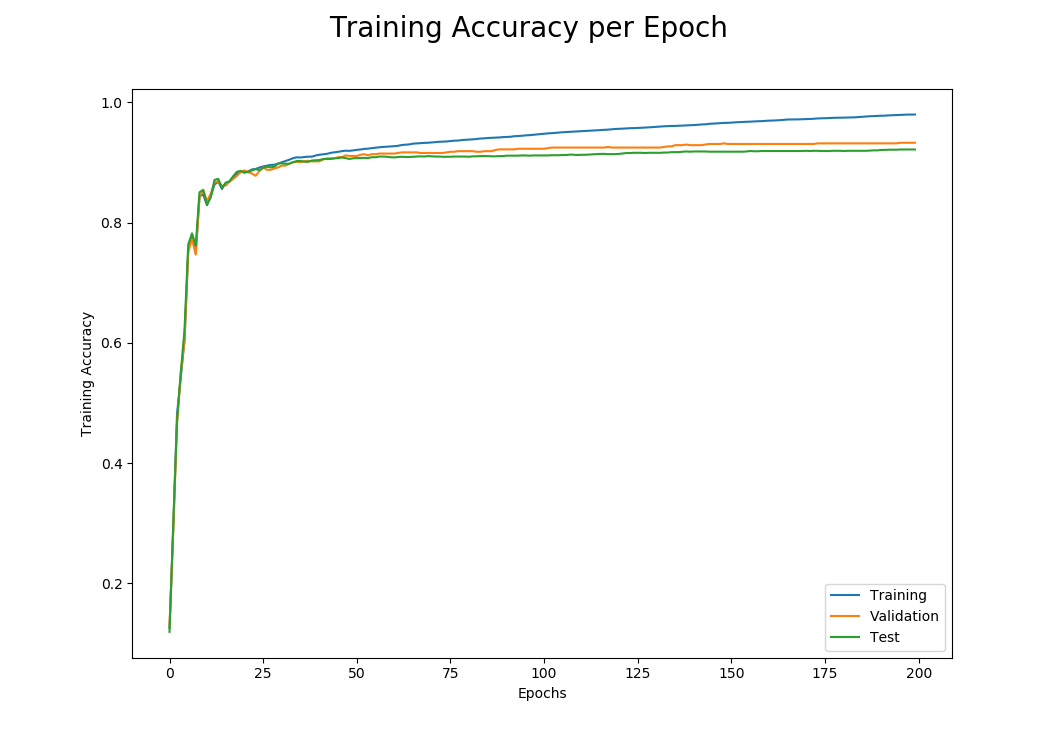

## Hyperparameter investigation [3 points]

Continue to use $\alpha=0.9$ and $\eta=10^{-5}$.

Test your network with 500, 1500, 2500 hidden nodes and train for 200 epochs. Comment based on the validation accuracy after how many epochs training could be terminated early. 

Plot the training and validation accuracy curves for all three network sizes and 200 training epochs, and report the test accuracy for your selected network size and training length. Show the plot and the accuracies in the next markdown cell.

(Training of the large network for 200 epochs should take about 30-60 mins.)

In [ ]:
#  500 Hidden Node Weight Initialization
hidden_nodes = 500
hiddenVariance = 2 / (trainData.shape[1] + hidden_nodes)
outputVariance = 2 / (hidden_nodes + 10)
hiddenWeights1 = np.random.normal(mu, np.sqrt(hiddenVariance), (trainData.shape[1] + 1, hidden_nodes))
outputWeights1 = np.random.normal(mu, np.sqrt(outputVariance), (hidden_nodes + 1,10))
outputWeights1[0,:] = 0
hiddenWeights1[0,:] = 0
hiddenWeights1, outputWeights1, Ein1, Ein_val1, Ein_test1, accuracy1, accuracy_val1, accuracy_test1 \
    = trainNN(learningRate, momentum, \
    epochs, hiddenWeights1, outputWeights1, trainData, trainTarget, \
    validData, validTarget, testData, testTarget)

#  1500 Hidden Node Weight Initialization
hidden_nodes = 1500
hiddenVariance = 2 / (trainData.shape[1] + hidden_nodes)
outputVariance = 2 / (hidden_nodes + 10)
hiddenWeights2 = np.random.normal(mu, np.sqrt(hiddenVariance), (trainData.shape[1] + 1, hidden_nodes))
outputWeights2 = np.random.normal(mu, np.sqrt(outputVariance), (hidden_nodes + 1,10))
outputWeights2[0,:] = 0
hiddenWeights2[0,:] = 0
hiddenWeights2, outputWeights2, Ein2, Ein_val2, Ein_test2, accuracy2, accuracy_val2, accuracy_test2 \
    = trainNN(learningRate, momentum, \
    epochs, hiddenWeights2, outputWeights2, trainData, trainTarget, \
    validData, validTarget, testData, testTarget)

#  2500 Hidden Node Weight Initialization
hidden_nodes = 2500
hiddenVariance = 2 / (trainData.shape[1] + hidden_nodes)
outputVariance = 2 / (hidden_nodes + 10)
hiddenWeights3 = np.random.normal(mu, np.sqrt(hiddenVariance), (trainData.shape[1] + 1, hidden_nodes))
outputWeights3 = np.random.normal(mu, np.sqrt(outputVariance), (hidden_nodes + 1,10))
outputWeights3[0,:] = 0
hiddenWeights3[0,:] = 0
hiddenWeights3, outputWeights3, Ein3, Ein_val3, Ein_test3, accuracy3, accuracy_val3, accuracy_test3 \
    = trainNN(learningRate, momentum, \
    epochs, hiddenWeights3, outputWeights3, trainData, trainTarget, \
    validData, validTarget, testData, testTarget)


#Plot results and print accuracy data
fig, axs = plt.subplots(3, 1, constrained_layout=True)
axs[0].set_title('500 Hidden Nodes', fontsize = '20')
axs[0].plot(accuracy1, label='Training');
axs[0].plot(accuracy_val1, label='Validation');
axs[0].set_ylabel('Training Accuracy');
axs[0].set_xlabel('Epochs');
axs[0].legend(loc='lower right')
axs[1].set_title('1500 Hidden Nodes', fontsize = '20')
axs[1].plot(accuracy2, label='Training');
axs[1].plot(accuracy_val2, label='Validation');
axs[1].set_ylabel('Training Accuracy');
axs[1].set_xlabel('Epochs');
axs[1].legend(loc='lower right')
axs[2].set_title('2500 Hidden Nodes', fontsize = '20')
axs[2].plot(accuracy3, label='Training');
axs[2].plot(accuracy_val3, label='Validation');
axs[2].set_ylabel('Training Accuracy');
axs[2].set_xlabel('Epochs');
axs[2].legend(loc='lower right')
sH, sO, xH, x1_train = fwdProp(trainData, hiddenWeights1, outputWeights1)
sH, sO, xH, x1_val = fwdProp(validData, hiddenWeights1, outputWeights1)
sH, sO, xH, x2_train = fwdProp(trainData, hiddenWeights2, outputWeights2)
sH, sO, xH, x2_val = fwdProp(validData, hiddenWeights2, outputWeights2)
sH, sO, xH, x3_train = fwdProp(trainData, hiddenWeights3, outputWeights3)
sH, sO, xH, x3_val = fwdProp(validData, hiddenWeights3, outputWeights3)
print("Training Accuracy, 500 nodes: " + str(trainAccuracy(trainTarget, x1_train)))
print("Validation Accuracy, 500 nodes: " + str(trainAccuracy(validTarget, x1_val)))
print("Training Accuracy, 1500 nodes: " + str(trainAccuracy(trainTarget, x2_train)))
print("Validation Accuracy, 1500 nodes: " + str(trainAccuracy(validTarget, x2_val)))
print("Training Accuracy, 2500 nodes: " + str(trainAccuracy(trainTarget, x3_train)))
print("Validation Accuracy, 2500 nodes: " + str(trainAccuracy(validTarget, x3_val)))

Early termination of training can be determined by evaluating the change in validation accuracy. When validation accuracy has reached it's peak, the training should be terminated. Beyond this point, the training accuracy may continue to increase, potentially leading to overfitting the training set. 

Less hidden nodes are much quicker to train than more hidden notes in a neural network. This means smaller neural nets will likely need to be terminated earlier than larger neural nets to prevent overfitting. 

Tables 2 summarizes the training and validation data accuracy after 200 epochs. 

Table 2: Training and validation accuracies with various hidden layer lengths
$$
\begin{array} {|r|r|}\hline & 500 \ Nodes & 1500 \ Nodes & 2500 \ Nodes \\  
\hline Training \ Accuracy & 0.975 & 0.981 & 0.982 \\ 
\hline Validation \ Accuracy & 0.932 & 0.933 & 0.936 \\ 
\hline  \end{array}
$$


The optimal training length for the validation data was discovered by finding the epoch where the accuracy was greatest. The peaks were not discovered within 200 epochs, thus a 500 epoch test was performed. 

Table 3 summarizes the test data accuracy at the optimal training length. It can be seen that the test accuracy is very close when the neural net training is stopped at the peak of the validation accuracy. 

Table 3: Test dataset optimal training length with various hidden layer lengths
$$
\begin{array} {|r|r|}\hline & 500 \ Nodes & 1500 \ Nodes & 2500 \ Nodes \\  
\hline Training \ Length & 227 & 399 & 466 \\ 
\hline Test \ Data \ Accuracy & 0.919 & 0.923 & 0.921 \\ 
\hline  \end{array}
$$
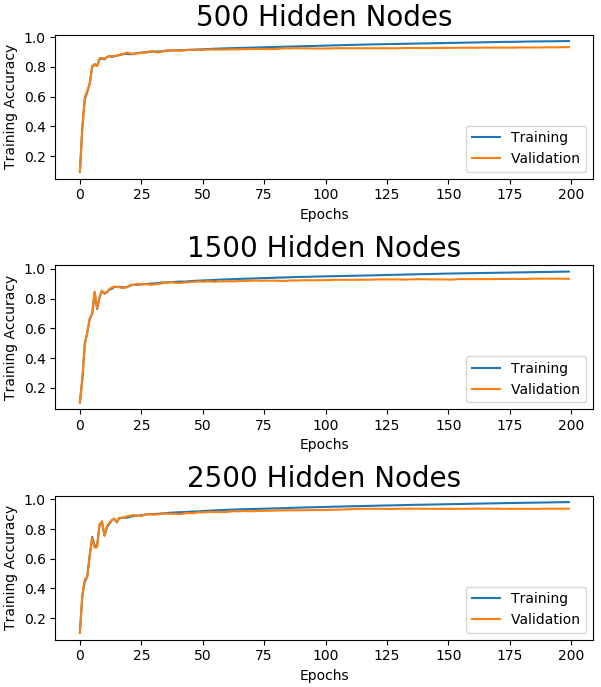
